## **Nature of the Work**

This project performs a **predictive modeling project** using **time series and energy data** combined with **weather information** for Madrid. The work involves:

1. **Data Integration and Cleaning**

   * Merging electricity generation, load, and price data with weather observations.
   * Handling missing values, creating lag and rolling features, and computing ratios for different energy sources.

2. **Feature Engineering**

   * Extracting time-based features (hour, day, month, week, weekend).
   * Creating new categorical features, such as `time_of_day` (dawn, morning, afternoon, evening, night).
   * Calculating forecast errors and supply-load differences.

3. **Exploratory Data Analysis (EDA)**

   * Understanding the distributions, trends, and seasonality of electricity prices and load.
   * Visualizing relationships between generation types, weather variables, and prices.
   * Checking correlations and feature importance to guide model selection.

4. **Predictive Modeling**

   * Training machine learning models to **predict load** based on historical, weather, and generation data.
   * Using lagged and rolling statistics to capture temporal patterns.
   * Evaluating models with metrics such as **MAE, RMSE, or MAPE** and **Others**.

5. **Deployment Preparation**

   * Refactoring analysis into scripts (`train.py`, `predict.py`, `serve.py`).
   * Packaging the model into a **Dockerized web service** for reproducibility and deployment.

## **Objectives of the Project**

1. **Predictive Objective**

   * Accurately forecast the **total load** in Madrid using historical generation, weather, and temporal data.

2. **Analytical Objective**

   * Understand how **different energy sources**, weather conditions, and temporal factors affect electricity load.
   * Identify key predictors that drive variability in the electricity market.

3. **Practical / Applied Objective**

   * Develop a **reproducible ML workflow** including feature engineering, model training, evaluation, and deployment.
   * Demonstrate **end-to-end ML skills**, from data preprocessing to deployment, in line with the ML Zoomcamp midterm requirements.


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

# --- Modeling: train baseline regressors and save best ---
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import joblib

# Download latest version
path = kagglehub.dataset_download("nicholasjhana/energy-consumption-generation-prices-and-weather")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\asant\.cache\kagglehub\datasets\nicholasjhana\energy-consumption-generation-prices-and-weather\versions\1


In [124]:
energy_file = [os.path.join(path, df) for df in os.listdir(path)][0]
weather_file = [os.path.join(path, df) for df in os.listdir(path)][1]
energy = pd.read_csv(energy_file)
weather = pd.read_csv(weather_file)
energy

time  generation biomass  \
0      2015-01-01 00:00:00+01:00               447.0   
1      2015-01-01 01:00:00+01:00               449.0   
2      2015-01-01 02:00:00+01:00               448.0   
3      2015-01-01 03:00:00+01:00               438.0   
4      2015-01-01 04:00:00+01:00               428.0   
...                          ...                 ...   
35059  2018-12-31 19:00:00+01:00               297.0   
35060  2018-12-31 20:00:00+01:00               296.0   
35061  2018-12-31 21:00:00+01:00               292.0   
35062  2018-12-31 22:00:00+01:00               293.0   
35063  2018-12-31 23:00:00+01:00               290.0   

       generation fossil brown coal/lignite  \
0                                     329.0   
1                                     328.0   
2                                     323.0   
3                                     254.0   
4                                     187.0   
...                                     ...   
35059                                   0.0   
35060                                   0.0   
35061                                   0.0   
35062                                   0.0   
35063                                   0.0   

       generation fossil coal-derived gas  generation fossil gas  \
0                                     0.0                 4844.0   
1                                     0.0                 5196.0   
2                                     0.0                 4857.0   
3                                     0.0                 4314.0   
4                                     0.0                 4130.0   
...                                   ...                    ...   
35059                                 0.0                 7634.0   
35060                                 0.0                 7241.0   
35061                                 0.0                 7025.0   
35062                                 0.0                 6562.0   
35063                                 0.0                 6926.0   

       generation fossil hard coal  generation fossil oil  \
0                           4821.0                  162.0   
1                           4755.0                  158.0   
2                           4581.0                  157.0   
3                           4131.0                  160.0   
4                           3840.0                  156.0   
...                            ...                    ...   
35059                       2628.0                  178.0   
35060                       2566.0                  174.0   
35061                       2422.0                  168.0   
35062                       2293.0                  163.0   
35063                       2166.0                  163.0   

       generation fossil oil shale  generation fossil peat  \
0                              0.0                     0.0   
1                              0.0                     0.0   
2                              0.0                     0.0   
3                              0.0                     0.0   
4                              0.0                     0.0   
...                            ...                     ...   
35059                          0.0                     0.0   
35060                          0.0                     0.0   
35061                          0.0                     0.0   
35062                          0.0                     0.0   
35063                          0.0                     0.0   

       generation geothermal  ...  generation waste  generation wind offshore  \
0                        0.0  ...             196.0                       0.0   
1                        0.0  ...             195.0                       0.0   
2                        0.0  ...             196.0                       0.0   
3                        0.0  ...             191.0                       0.0   
4                        0.0  ...             189.0                       0.0   
...      

In [125]:
# parse dates (handle tz-aware datetimes)
energy['time'] = pd.to_datetime(energy['time'], errors='coerce', utc=True)
weather['dt_iso'] = pd.to_datetime(weather['dt_iso'], errors='coerce', utc=True)

In [126]:
weather

dt_iso city_name     temp  temp_min  temp_max  \
0      2014-12-31 23:00:00+00:00  Valencia  270.475   270.475   270.475   
1      2015-01-01 00:00:00+00:00  Valencia  270.475   270.475   270.475   
2      2015-01-01 01:00:00+00:00  Valencia  269.686   269.686   269.686   
3      2015-01-01 02:00:00+00:00  Valencia  269.686   269.686   269.686   
4      2015-01-01 03:00:00+00:00  Valencia  269.686   269.686   269.686   
...                          ...       ...      ...       ...       ...   
178391 2018-12-31 18:00:00+00:00   Seville  287.760   287.150   288.150   
178392 2018-12-31 19:00:00+00:00   Seville  285.760   285.150   286.150   
178393 2018-12-31 20:00:00+00:00   Seville  285.150   285.150   285.150   
178394 2018-12-31 21:00:00+00:00   Seville  284.150   284.150   284.150   
178395 2018-12-31 22:00:00+00:00   Seville  283.970   282.150   285.150   

        pressure  humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  \
0           1001        77           1        62      0.0      0.0      0.0   
1           1001        77           1        62      0.0      0.0      0.0   
2           1002        78           0        23      0.0      0.0      0.0   
3           1002        78           0        23      0.0      0.0      0.0   
4           1002        78           0        23      0.0      0.0      0.0   
...          ...       ...         ...       ...      ...      ...      ...   
178391      1028        54           3        30      0.0      0.0      0.0   
178392      1029        62           3        30      0.0      0.0      0.0   
178393      1028        58           4        50      0.0      0.0      0.0   
178394      1029        57           4        60      0.0      0.0      0.0   
178395      1029        70           3        50      0.0      0.0      0.0   

        clouds_all  weather_id weather_main weather_description weather_icon  
0                0         800        clear        sky is clear          01n  
1                0         800        clear        sky is clear          01n  
2                0         800        clear        sky is clear          01n  
3                0         800        clear        sky is clear          01n  
4                0         800        clear        sky is clear          01n  
...            ...         ...          ...                 ...          ...  
178391           0         800        clear        sky is clear          01n  
178392           0         800        clear        sky is clear          01n  
178393           0         800        clear        sky is clear          01n  
178394           0         800        clear        sky is clear          01n  
178395           0         800        clear        sky is clear          01n  

[178396 rows x 17 columns]

In [127]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   dt_iso               178396 non-null  datetime64[ns, UTC]
 1   city_name            178396 non-null  object             
 2   temp                 178396 non-null  float64            
 3   temp_min             178396 non-null  float64            
 4   temp_max             178396 non-null  float64            
 5   pressure             178396 non-null  int64              
 6   humidity             178396 non-null  int64              
 7   wind_speed           178396 non-null  int64              
 8   wind_deg             178396 non-null  int64              
 9   rain_1h              178396 non-null  float64            
 10  rain_3h              178396 non-null  float64            
 11  snow_3h              178396 non-null  float64            
 12  cl

In [128]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35045 non-null  float64            
 2   generation fossil brown coal/lignite         35046 non-null  float64            
 3   generation fossil coal-derived gas           35046 non-null  float64            
 4   generation fossil gas                        35046 non-null  float64            
 5   generation fossil hard coal                  35046 non-null  float64            
 6   generation fossil oil                        35045 non-null  float64            
 7   generation fossil oil shale                  35046 non-null  float64            
 8   generation fossil peat    

## Data Cleaning

In [129]:
# drop columns with all missing values and rows with any missing values
energy = energy.dropna(axis=1, how='all')
energy = energy.dropna(axis=0, how='any')

In [130]:
# Use frequent city
weather['city_name'].value_counts()

madrid_weather = weather[weather['city_name'] == 'Madrid'].copy().reset_index()
madrid_weather

index                    dt_iso city_name     temp  temp_min  temp_max  \
0      35145 2014-12-31 23:00:00+00:00    Madrid  267.325   267.325   267.325   
1      35146 2015-01-01 00:00:00+00:00    Madrid  267.325   267.325   267.325   
2      35147 2015-01-01 01:00:00+00:00    Madrid  266.186   266.186   266.186   
3      35148 2015-01-01 02:00:00+00:00    Madrid  266.186   266.186   266.186   
4      35149 2015-01-01 03:00:00+00:00    Madrid  266.186   266.186   266.186   
...      ...                       ...       ...      ...       ...       ...   
36262  71407 2018-12-31 18:00:00+00:00    Madrid  283.560   282.150   285.150   
36263  71408 2018-12-31 19:00:00+00:00    Madrid  280.120   278.150   281.150   
36264  71409 2018-12-31 20:00:00+00:00    Madrid  278.150   278.150   278.150   
36265  71410 2018-12-31 21:00:00+00:00    Madrid  276.570   276.150   277.150   
36266  71411 2018-12-31 22:00:00+00:00    Madrid  275.150   275.150   275.150   

       pressure  humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  \
0           971        63           1       309      0.0      0.0      0.0   
1           971        63           1       309      0.0      0.0      0.0   
2           971        64           1       273      0.0      0.0      0.0   
3           971        64           1       273      0.0      0.0      0.0   
4           971        64           1       273      0.0      0.0      0.0   
...         ...       ...         ...       ...      ...      ...      ...   
36262      1030        88           1       280      0.0      0.0      0.0   
36263      1031        52           1       260      0.0      0.0      0.0   
36264      1030        65           1       340      0.0      0.0      0.0   
36265      1031        69           2       340      0.0      0.0      0.0   
36266      1031        74           1       360      0.0      0.0      0.0   

       clouds_all  weather_id weather_main weather_description weather_icon  
0               0         800        clear        sky is clear          01n  
1               0         800        clear        sky is clear          01n  
2               0         800        clear        sky is clear          01n  
3               0         800        clear        sky is clear          01n  
4               0         800        clear        sky is clear          01n  
...           ...         ...          ...                 ...          ...  
36262           0         800        clear        sky is clear          01n  
36263           0         800        clear        sky is clear          01n  
36264           0         800        clear        sky is clear          01n  
36265           0         800        clear        sky is clear          01n  
36266           0         800        clear        sky is clear          01n  

[36267 rows x 18 columns]

In [131]:
madrid_df = energy.merge(
    madrid_weather,
    left_on='time',
    right_on='dt_iso',
    how='inner'
)

madrid_df

time  generation biomass  \
0     2014-12-31 23:00:00+00:00               447.0   
1     2015-01-01 00:00:00+00:00               449.0   
2     2015-01-01 01:00:00+00:00               448.0   
3     2015-01-01 02:00:00+00:00               438.0   
4     2015-01-01 03:00:00+00:00               428.0   
...                         ...                 ...   
36215 2018-12-31 18:00:00+00:00               297.0   
36216 2018-12-31 19:00:00+00:00               296.0   
36217 2018-12-31 20:00:00+00:00               292.0   
36218 2018-12-31 21:00:00+00:00               293.0   
36219 2018-12-31 22:00:00+00:00               290.0   

       generation fossil brown coal/lignite  \
0                                     329.0   
1                                     328.0   
2                                     323.0   
3                                     254.0   
4                                     187.0   
...                                     ...   
36215                                   0.0   
36216                                   0.0   
36217                                   0.0   
36218                                   0.0   
36219                                   0.0   

       generation fossil coal-derived gas  generation fossil gas  \
0                                     0.0                 4844.0   
1                                     0.0                 5196.0   
2                                     0.0                 4857.0   
3                                     0.0                 4314.0   
4                                     0.0                 4130.0   
...                                   ...                    ...   
36215                                 0.0                 7634.0   
36216                                 0.0                 7241.0   
36217                                 0.0                 7025.0   
36218                                 0.0                 6562.0   
36219                                 0.0                 6926.0   

       generation fossil hard coal  generation fossil oil  \
0                           4821.0                  162.0   
1                           4755.0                  158.0   
2                           4581.0                  157.0   
3                           4131.0                  160.0   
4                           3840.0                  156.0   
...                            ...                    ...   
36215                       2628.0                  178.0   
36216                       2566.0                  174.0   
36217                       2422.0                  168.0   
36218                       2293.0                  163.0   
36219                       2166.0                  163.0   

       generation fossil oil shale  generation fossil peat  \
0                              0.0                     0.0   
1                              0.0                     0.0   
2                              0.0                     0.0   
3                              0.0                     0.0   
4                              0.0                     0.0   
...                            ...                     ...   
36215                          0.0                     0.0   
36216                          0.0                     0.0   
36217                          0.0                     0.0   
36218                          0.0                     0.0   
36219                          0.0                     0.0   

       generation geothermal  ...  wind_speed  wind_deg  rain_1h  rain_3h  \
0                        0.0  ...           1       309      0.0      0.0   
1                        0.0  ...           1       309      0.0      0.0   
2                        0.0  ...           1       273      0.0      0.0   
3                        0.0  ...           1       273      0.0      0.0   
4                        0.0  ...           1       273      0.0      0.0   
...                      ...  ...         ..

## Feature Engineering

In [132]:
# Hour, day, month
madrid_df['hour'] = madrid_df['time'].dt.hour
madrid_df['dayofweek'] = madrid_df['time'].dt.dayofweek
madrid_df['month'] = madrid_df['time'].dt.month
madrid_df['weekofyear'] = madrid_df['time'].dt.isocalendar().week.astype(int)
madrid_df['is_weekend'] = madrid_df['dayofweek'].isin([5,6]).astype(int)

def time_of_day(hour):
    if 5 <= hour < 8:
        return 'dawn'
    elif 8 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    elif 21 <= hour < 24:
        return 'night'
    else:  # 0 <= hour < 5
        return 'late_night'

madrid_df['time_of_day'] = madrid_df['hour'].apply(time_of_day)

# Lag Features
madrid_df['price_lag1'] = madrid_df['price day ahead'].shift(1)
madrid_df['price_lag24'] = madrid_df['price day ahead'].shift(24)
madrid_df['total_load_lag1'] = madrid_df['total load actual'].shift(1)
madrid_df['total_load_lag24'] = madrid_df['total load actual'].shift(24)

# Rolling Mean Features
madrid_df['price_roll3'] = madrid_df['price day ahead'].shift(1).rolling(3).mean()
madrid_df['price_roll24'] = madrid_df['price day ahead'].shift(1).rolling(24).mean()
madrid_df['load_roll3'] = madrid_df['total load actual'].shift(1).rolling(3).mean()
madrid_df['load_roll24'] = madrid_df['total load actual'].shift(1).rolling(24).mean()

# Relative contribution of each source
generation_cols = [col for col in madrid_df.columns if 'generation' in col]
madrid_df['total_generation'] = madrid_df[generation_cols].sum(axis=1)
for col in generation_cols:
    madrid_df[col + '_ratio'] = madrid_df[col] / (madrid_df['total_generation'] + 1e-3)

# Custom Features
madrid_df['supply_minus_load'] = madrid_df['total_generation'] - madrid_df['total load actual']
madrid_df['forecast_error_load'] = madrid_df['total load forecast'] - madrid_df['total load actual']
madrid_df['forecast_error_solar'] = madrid_df['forecast solar day ahead'] - madrid_df['generation solar']
madrid_df['forecast_error_wind'] = madrid_df['forecast wind onshore day ahead'] - madrid_df['generation wind onshore']


data = pd.get_dummies(madrid_df, columns=['weather_main'], drop_first=True)
df = data.dropna(axis=0, how='any')
df

time  generation biomass  \
24    2015-01-01 23:00:00+00:00               368.0   
25    2015-01-02 00:00:00+00:00               368.0   
26    2015-01-02 01:00:00+00:00               358.0   
27    2015-01-02 02:00:00+00:00               353.0   
28    2015-01-02 03:00:00+00:00               354.0   
...                         ...                 ...   
36215 2018-12-31 18:00:00+00:00               297.0   
36216 2018-12-31 19:00:00+00:00               296.0   
36217 2018-12-31 20:00:00+00:00               292.0   
36218 2018-12-31 21:00:00+00:00               293.0   
36219 2018-12-31 22:00:00+00:00               290.0   

       generation fossil brown coal/lignite  \
24                                      0.0   
25                                      0.0   
26                                      0.0   
27                                      0.0   
28                                      0.0   
...                                     ...   
36215                                   0.0   
36216                                   0.0   
36217                                   0.0   
36218                                   0.0   
36219                                   0.0   

       generation fossil coal-derived gas  generation fossil gas  \
24                                    0.0                 3189.0   
25                                    0.0                 2902.0   
26                                    0.0                 2772.0   
27                                    0.0                 2936.0   
28                                    0.0                 2893.0   
...                                   ...                    ...   
36215                                 0.0                 7634.0   
36216                                 0.0                 7241.0   
36217                                 0.0                 7025.0   
36218                                 0.0                 6562.0   
36219                                 0.0                 6926.0   

       generation fossil hard coal  generation fossil oil  \
24                          1291.0                  193.0   
25                          1190.0                  192.0   
26                          1023.0                  189.0   
27                          1016.0                  188.0   
28                          1103.0                  189.0   
...                            ...                    ...   
36215                       2628.0                  178.0   
36216                       2566.0                  174.0   
36217                       2422.0                  168.0   
36218                       2293.0                  163.0   
36219                       2166.0                  163.0   

       generation fossil oil shale  generation fossil peat  \
24                             0.0                     0.0   
25                             0.0                     0.0   
26                             0.0                     0.0   
27                             0.0                     0.0   
28                             0.0                     0.0   
...                            ...                     ...   
36215                          0.0                     0.0   
36216                          0.0                     0.0   
36217                          0.0                     0.0   
36218                          0.0                     0.0   
36219                          0.0                     0.0   

       generation geothermal  ...  forecast_error_solar  forecast_error_wind  \
24                       0.0  ...                 -49.0                 97.0   
25                       0.0  ...                 -19.0                -42.0   
26                       0.0  ...                 -11.0                201.0   
27                       0.0  ...                 -21.0                166.0   
28                       0.0  ...                 -22.0                111.0   
...                      .

## EDA
### Check Basic Statistics

In [133]:
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Index: 36196 entries, 24 to 36219
Data columns (total 91 columns):
 #   Column                                             Non-Null Count  Dtype              
---  ------                                             --------------  -----              
 0   time                                               36196 non-null  datetime64[ns, UTC]
 1   generation biomass                                 36196 non-null  float64            
 2   generation fossil brown coal/lignite               36196 non-null  float64            
 3   generation fossil coal-derived gas                 36196 non-null  float64            
 4   generation fossil gas                              36196 non-null  float64            
 5   generation fossil hard coal                        36196 non-null  float64            
 6   generation fossil oil                              36196 non-null  float64            
 7   generation fossil oil shale                        36196 non-n

count         mean          std  \
generation biomass                    36196.0   382.007957    84.984450   
generation fossil brown coal/lignite  36196.0   448.488231   354.057196   
generation fossil coal-derived gas    36196.0     0.000000     0.000000   
generation fossil gas                 36196.0  5640.025500  2214.484713   
generation fossil hard coal           36196.0  4249.194137  1960.249056   
...                                       ...          ...          ...   
generation wind onshore_ratio         36196.0     0.189769     0.101570   
supply_minus_load                     36196.0   -75.321334  2569.906508   
forecast_error_load                   36196.0    10.733120   453.477006   
forecast_error_solar                  36196.0     7.165571   194.960223   
forecast_error_wind                   36196.0     4.790833   340.737810   

                                          min          25%          50%  \
generation biomass                        0.0   332.000000   366.000000   
generation fossil brown coal/lignite      0.0     0.000000   510.000000   
generation fossil coal-derived gas        0.0     0.000000     0.000000   
generation fossil gas                     0.0  4130.000000  4978.000000   
generation fossil hard coal               0.0  2519.000000  4469.000000   
...                                       ...          ...          ...   
generation wind onshore_ratio             0.0     0.108554     0.176375   
supply_minus_load                    -29663.0 -1881.000000  -455.000000   
forecast_error_load                   -6244.0  -221.250000    11.000000   
forecast_error_solar                  -1232.0   -64.000000   -12.000000   
forecast_error_wind                   -3375.0   -82.000000     6.000000   

                                              75%           max  
generation biomass                     423.000000    592.000000  
generation fossil brown coal/lignite   756.000000    999.000000  
generation fossil coal-derived gas       0.000000      0.000000  
generation fossil gas                 6465.000000  20034.000000  
generation fossil hard coal           5830.250000   8359.000000  
...                                           ...           ...  
generation wind onshore_ratio            0.260294      0.505701  
supply_minus_load                     1252.000000  11526.000000  
forecast_error_load                    243.000000  13506.000000  
forecast_error_solar                    69.000000   3087.000000  
forecast_error_wind                     96.000000   8536.000000  

[77 rows x 8 columns]

In [134]:
# Drop columns with min and max equal to each other
cols_to_drop = [col for col in df.columns if df[col].min() == df[col].max()]
df = df.drop(columns=cols_to_drop)
df.describe().T

count         mean          std  \
generation biomass                    36196.0   382.007957    84.984450   
generation fossil brown coal/lignite  36196.0   448.488231   354.057196   
generation fossil gas                 36196.0  5640.025500  2214.484713   
generation fossil hard coal           36196.0  4249.194137  1960.249056   
generation fossil oil                 36196.0   298.070229    52.218073   
...                                       ...          ...          ...   
generation wind onshore_ratio         36196.0     0.189769     0.101570   
supply_minus_load                     36196.0   -75.321334  2569.906508   
forecast_error_load                   36196.0    10.733120   453.477006   
forecast_error_solar                  36196.0     7.165571   194.960223   
forecast_error_wind                   36196.0     4.790833   340.737810   

                                          min          25%          50%  \
generation biomass                        0.0   332.000000   366.000000   
generation fossil brown coal/lignite      0.0     0.000000   510.000000   
generation fossil gas                     0.0  4130.000000  4978.000000   
generation fossil hard coal               0.0  2519.000000  4469.000000   
generation fossil oil                     0.0   263.000000   300.000000   
...                                       ...          ...          ...   
generation wind onshore_ratio             0.0     0.108554     0.176375   
supply_minus_load                    -29663.0 -1881.000000  -455.000000   
forecast_error_load                   -6244.0  -221.250000    11.000000   
forecast_error_solar                  -1232.0   -64.000000   -12.000000   
forecast_error_wind                   -3375.0   -82.000000     6.000000   

                                              75%           max  
generation biomass                     423.000000    592.000000  
generation fossil brown coal/lignite   756.000000    999.000000  
generation fossil gas                 6465.000000  20034.000000  
generation fossil hard coal           5830.250000   8359.000000  
generation fossil oil                  329.000000    449.000000  
...                                           ...           ...  
generation wind onshore_ratio            0.260294      0.505701  
supply_minus_load                     1252.000000  11526.000000  
forecast_error_load                    243.000000  13506.000000  
forecast_error_solar                    69.000000   3087.000000  
forecast_error_wind                     96.000000   8536.000000  

[65 rows x 8 columns]

In [135]:
df.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'index', 'dt_iso', 'temp', 'temp_min', 'temp_max',
       'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h',
       'snow_3h', 'clouds_all', 'weather_id', 'weather_description',
       'weather_icon', 'hour', 'dayofweek', 'month', 'weekofyear',
       'is_weekend', 'time_of_day', 'price_lag1', 'price_lag24',
       'total_load_lag1', 'total_load_

In [136]:
# Split data
train_size = int(len(df) * 0.6)
val_size = int(len(df) * 0.2)

train_df = df[:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df[train_size+val_size:]

### 2. Distribution Plots

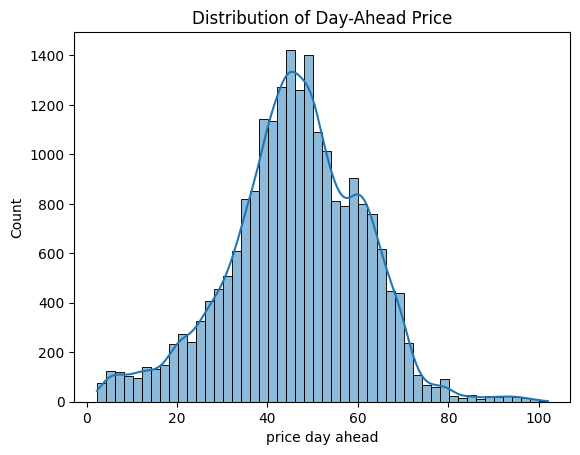

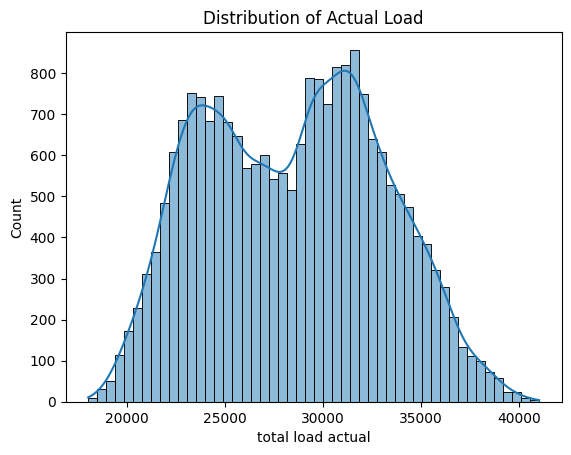

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

# Target price distribution
sns.histplot(train_df['price day ahead'], bins=50, kde=True)
plt.title("Distribution of Day-Ahead Price")
plt.show()

# Load distribution
sns.histplot(train_df['total load actual'], bins=50, kde=True)
plt.title("Distribution of Actual Load")
plt.show()

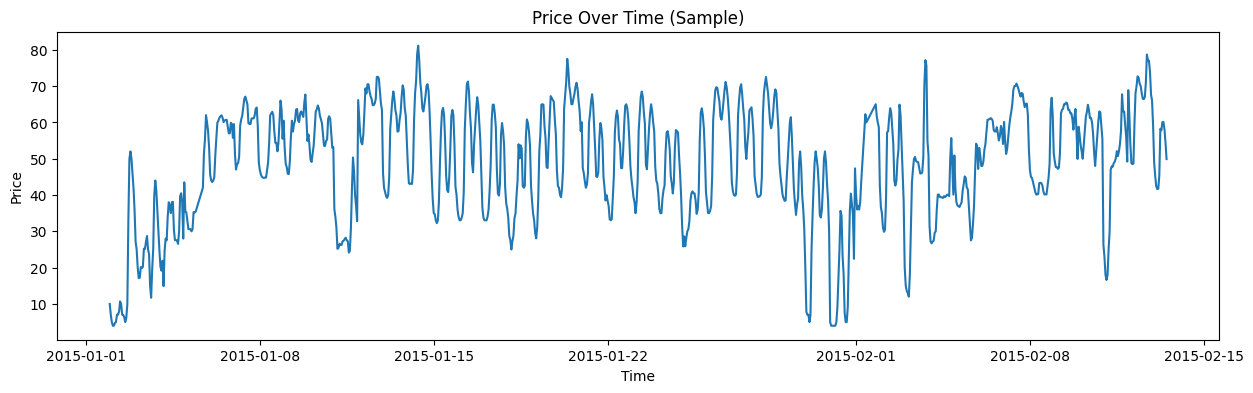

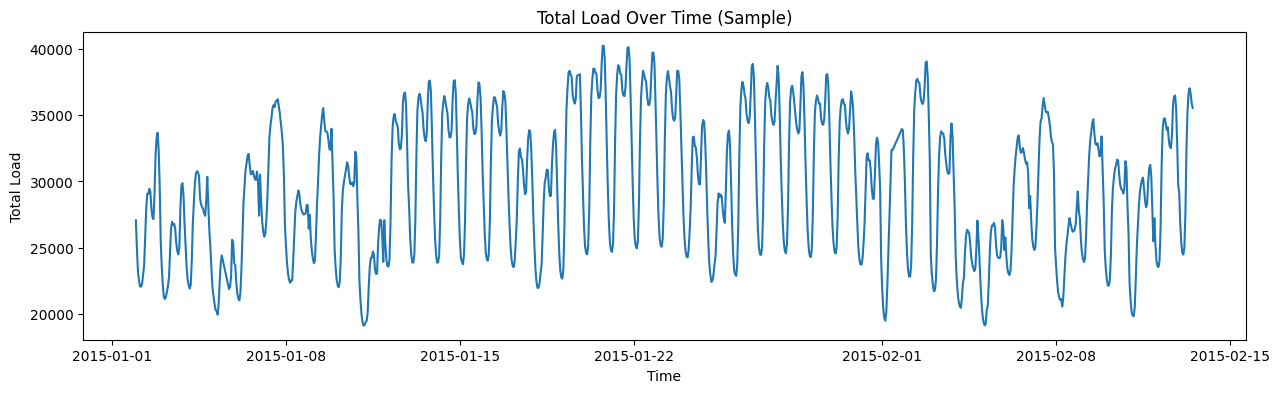

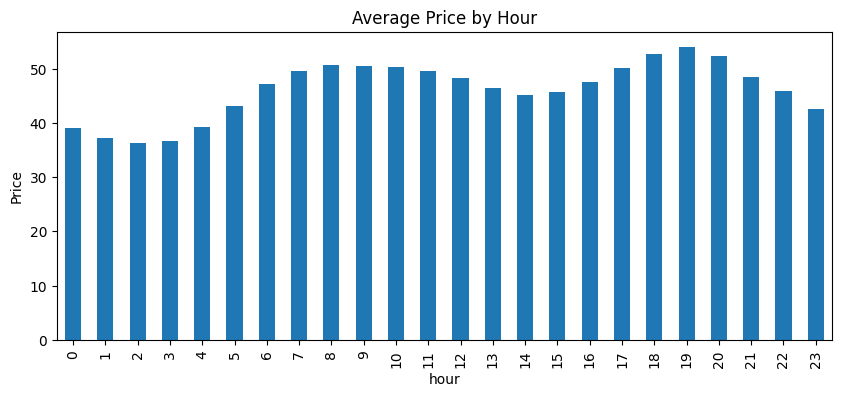

In [138]:
# Plot first 1000 hours
plt.figure(figsize=(15,4))
plt.plot(train_df['time'][:1000], df['price day ahead'][:1000])
plt.title("Price Over Time (Sample)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

# Plot first 1000 hours
plt.figure(figsize=(15,4))
plt.plot(train_df['time'][:1000], df['total load actual'][:1000])
plt.title("Total Load Over Time (Sample)")
plt.xlabel("Time")
plt.ylabel("Total Load")
plt.show()

# Average price by hour
hourly_avg = train_df.groupby('hour')['price day ahead'].mean()
hourly_avg.plot(kind='bar', figsize=(10,4))
plt.title("Average Price by Hour")
plt.ylabel("Price")
plt.show()

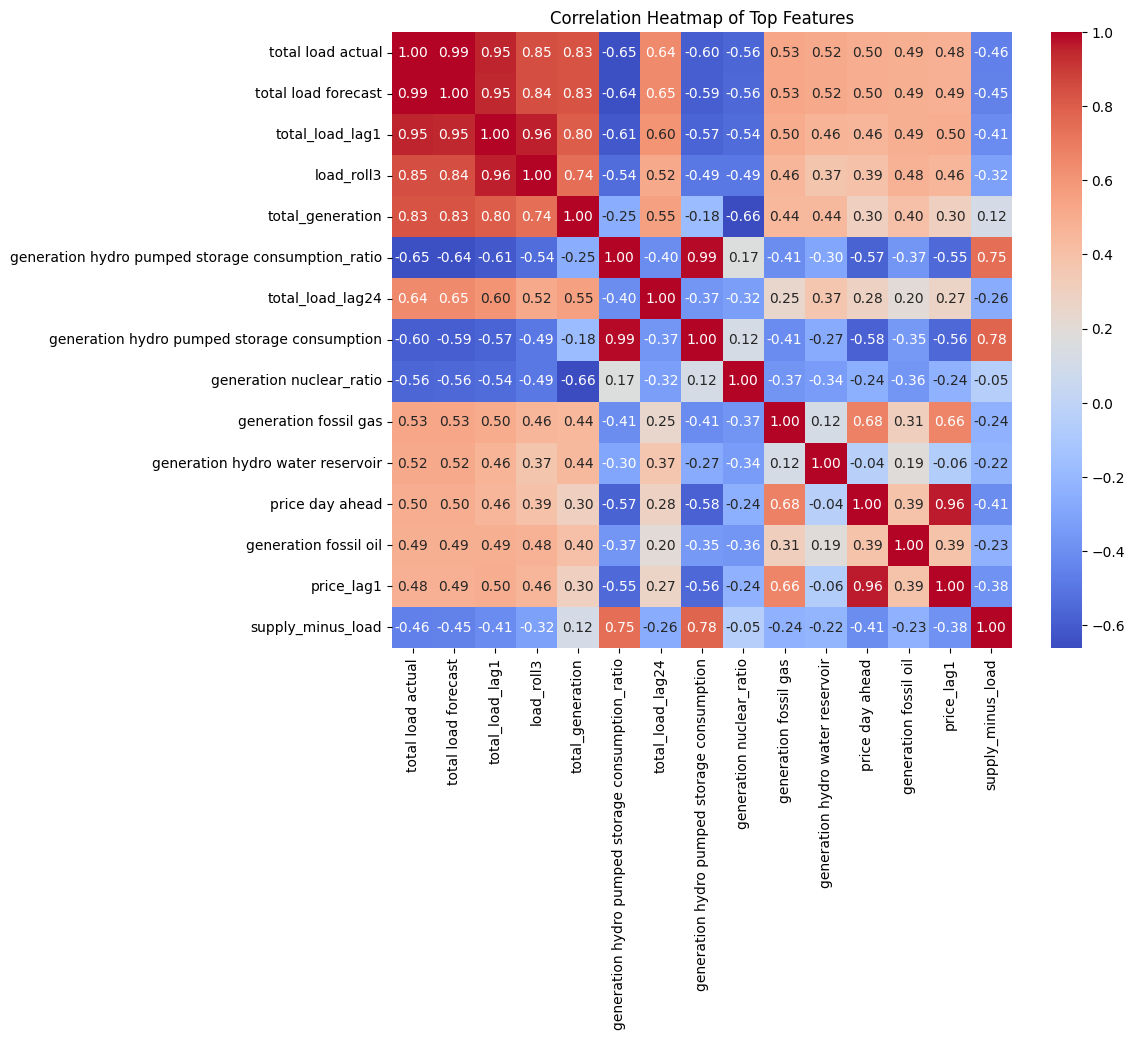

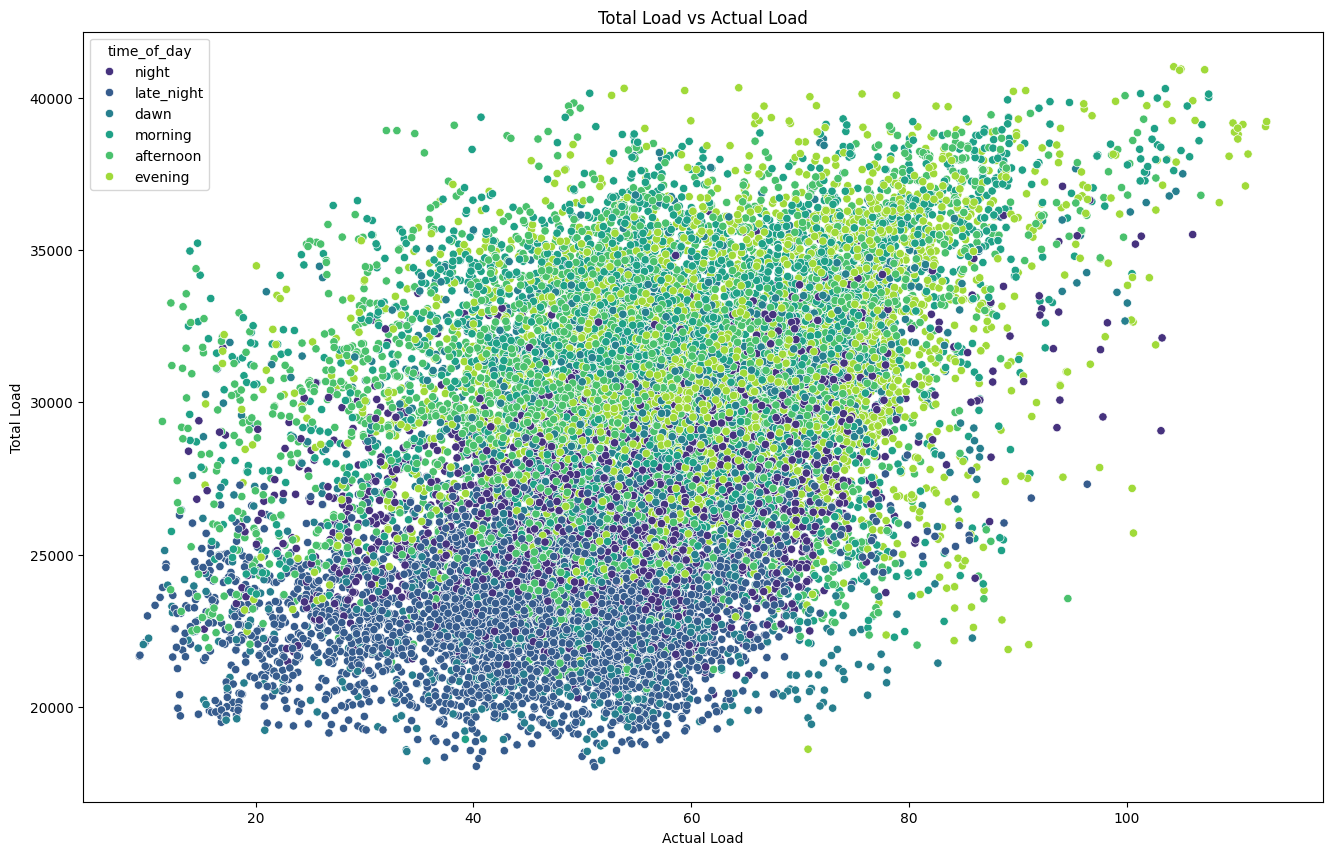

In [ ]:
corr_matrix = train_df[train_df.select_dtypes(include=['number']).columns].corr()
price_corr = corr_matrix['total load actual'].sort_values(ascending=False)
top_features = price_corr.abs().sort_values(ascending=False).head(15).index
plt.figure(figsize=(10,8))
sns.heatmap(train_df[top_features].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Top Features")
plt.show()

plt.figure(figsize=(16,10))
sns.scatterplot(x=train_df['price actual'], y=train_df['total load actual'], hue=train_df['time_of_day'], palette='viridis')
plt.title("Total Load vs Actual Load")
plt.xlabel("Actual Price")
plt.ylabel("Total Load")
plt.show()

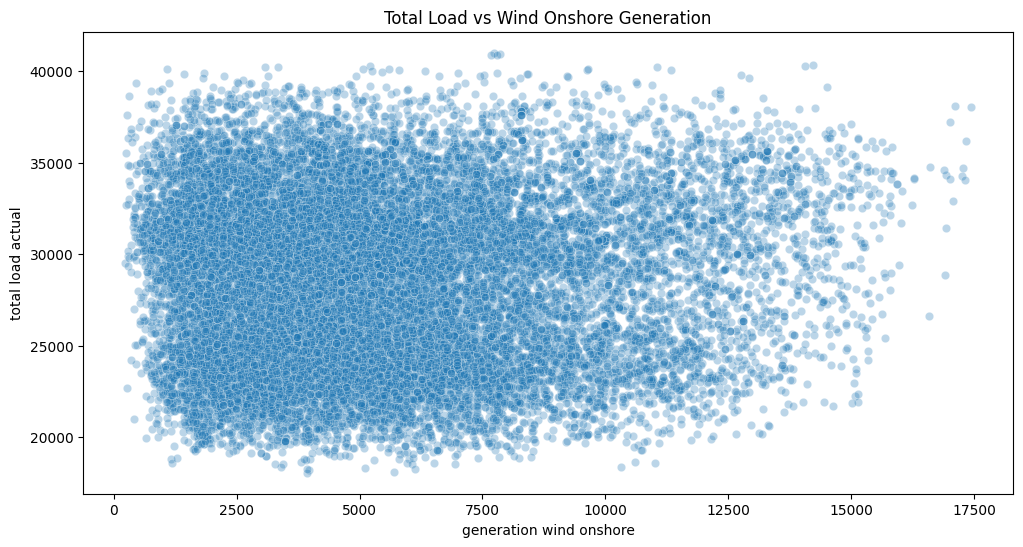

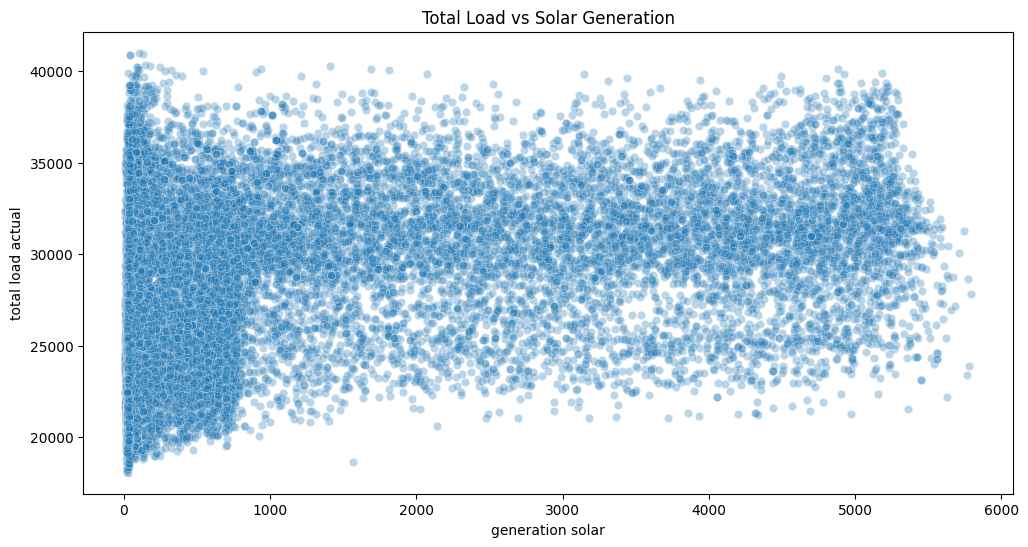

In [140]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='generation wind onshore', y='total load actual', data=train_df, alpha=0.3)
plt.title("Total Load vs Wind Onshore Generation")
plt.show()

plt.figure(figsize=(12,6))
sns.scatterplot(x='generation solar', y='total load actual', data=train_df, alpha=0.3)
plt.title("Total Load vs Solar Generation")
plt.show()

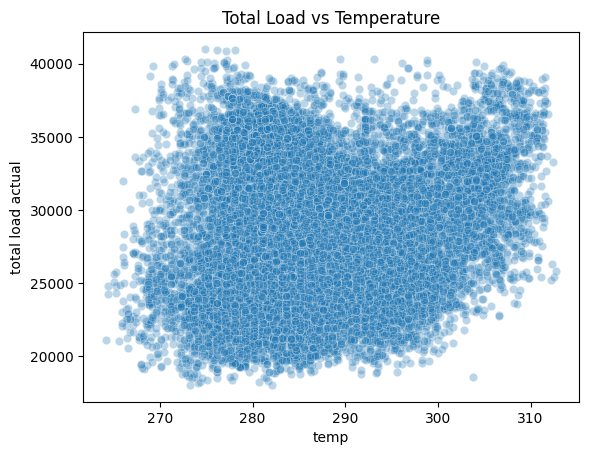

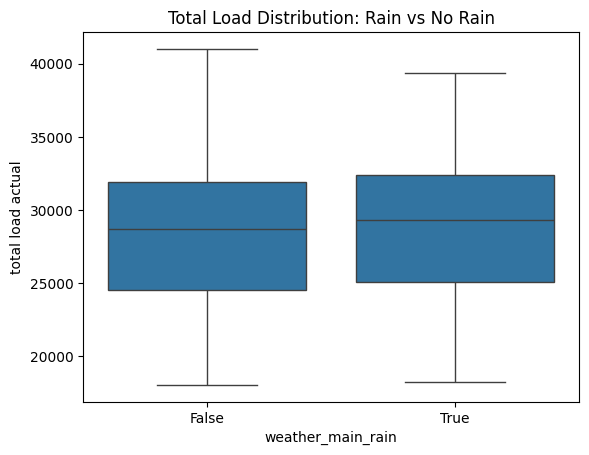

In [141]:
# Temperature vs Price
sns.scatterplot(x='temp', y='total load actual', data=train_df, alpha=0.3)
plt.title("Total Load vs Temperature")
plt.show()

# Rain effect
sns.boxplot(x='weather_main_rain', y='total load actual', data=train_df)
plt.title("Total Load Distribution: Rain vs No Rain")
plt.show()


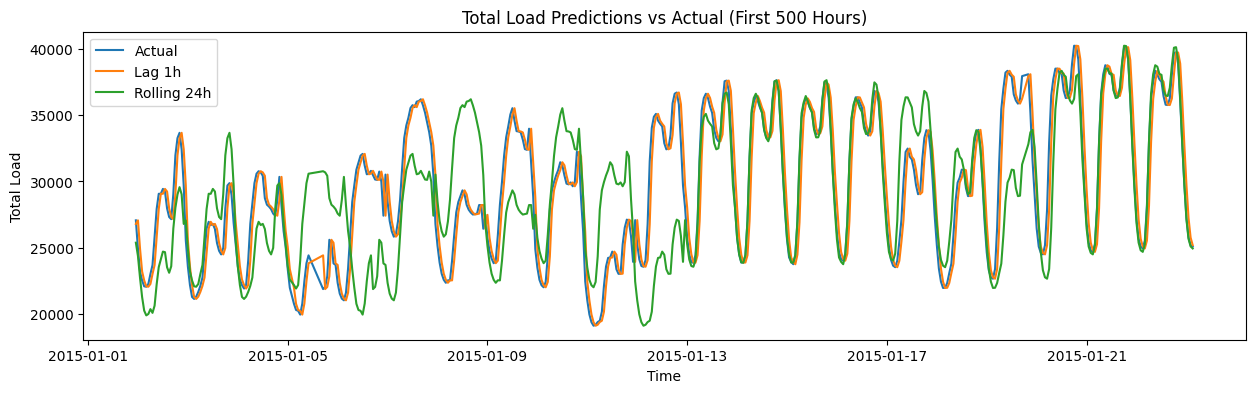

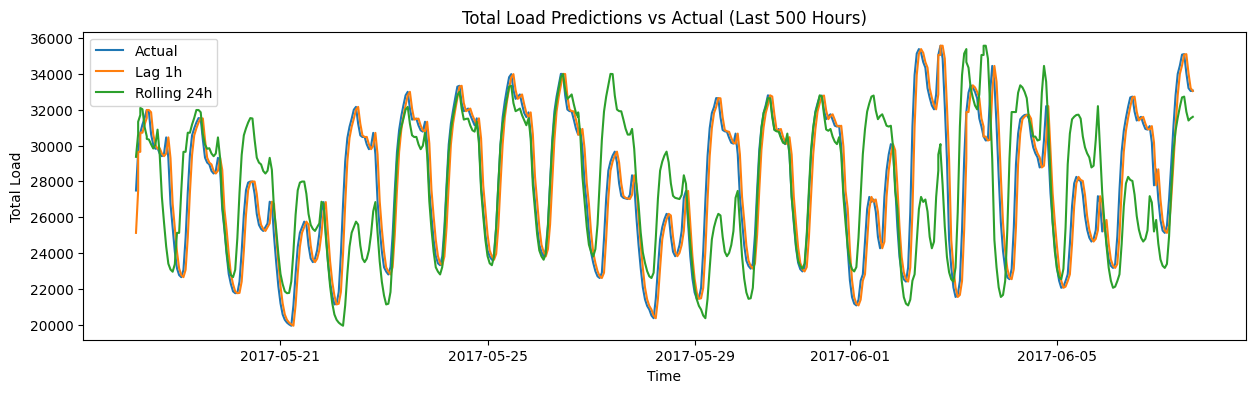

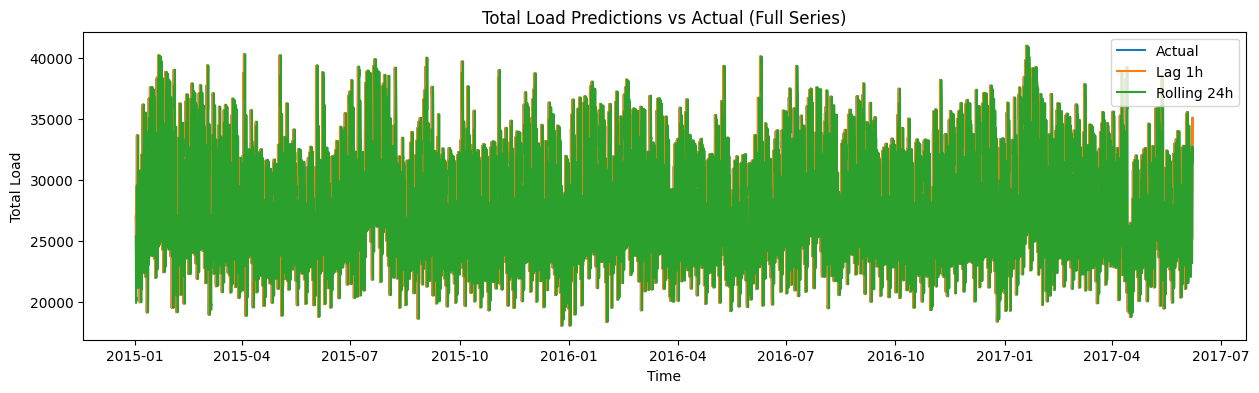

In [144]:
plt.figure(figsize=(15,4))
plt.plot('time', 'total load actual', data=train_df[:500], label='Actual')
plt.plot('time', 'total_load_lag1', data=train_df[:500], label='Lag 1h')
plt.plot('time', 'total_load_lag24', data=train_df[:500], label='Rolling 24h')
plt.xlabel("Time")
plt.ylabel("Total Load")
plt.title("Total Load Predictions vs Actual (First 500 Hours)")
plt.legend()
plt.show()

plt.figure(figsize=(15,4))
plt.plot('time', 'total load actual', data=train_df[-500:], label='Actual')
plt.plot('time', 'total_load_lag1', data=train_df[-500:], label='Lag 1h')
plt.plot('time', 'total_load_lag24', data=train_df[-500:], label='Rolling 24h')
plt.xlabel("Time")
plt.ylabel("Total Load")
plt.title("Total Load Predictions vs Actual (Last 500 Hours)")
plt.legend()
plt.show()

plt.figure(figsize=(15,4))
plt.plot('time', 'total load actual', data=train_df, label='Actual')
plt.plot('time', 'total_load_lag1', data=train_df, label='Lag 1h')
plt.plot('time', 'total_load_lag24', data=train_df, label='Rolling 24h')
plt.xlabel("Time")
plt.ylabel("Total Load")
plt.title("Total Load Predictions vs Actual (Full Series)")
plt.legend()
plt.show()

## Modelling

In [ ]:
# target and feature selection (numeric only)
target = 'total load actual'
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
if target not in numeric_cols:
    raise ValueError(f"Target column '{target}' not found in numeric columns")
features = [c for c in numeric_cols if c != target]

# Use previously split sets (train_df, val_df, test_df)
X_train = train_df[features].copy()
y_train = train_df[target].copy()
X_val = val_df[features].copy()
y_val = val_df[target].copy()
X_test = test_df[features].copy()
y_test = test_df[target].copy()

# Define models
models = dict()
models['lr'] = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
models['rf'] = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
models['gb'] = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)

results = {}
for name, model in models.items():
    print(f'--- Training {name} ---')
    model.fit(X_train, y_train)
    # validation metrics
    y_val_pred = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = root_mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    # test metrics
    y_test_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    results[name] = { 'model': model, 'val_mae': val_mae, 'val_rmse': val_rmse, 'val_r2': val_r2, 'test_mae': test_mae, 'test_rmse': test_rmse, 'test_r2': test_r2 }
    print(f'{name} — val RMSE: {val_rmse:.3f}, val MAE: {val_mae:.3f}, val R2: {val_r2:.3f}')
    print(f'{name} — test RMSE: {test_rmse:.3f}, test MAE: {test_mae:.3f}, test R2: {test_r2:.3f}')

# Summary table
import pandas as _pd
summary = _pd.DataFrame([
    { 'model': name, 'val_rmse': r['val_rmse'], 'val_mae': r['val_mae'], 'val_r2': r['val_r2'], 'test_rmse': r['test_rmse'], 'test_mae': r['test_mae'], 'test_r2': r['test_r2'] }
    for name, r in results.items()
]).set_index('model')
display(summary.sort_values('val_rmse'))

# Save best model by validation RMSE
os.makedirs('models', exist_ok=True)
best_name = summary['val_rmse'].idxmin()
best_model = results[best_name]['model']
model_path = os.path.join('models', f'best_model_{best_name}.pkl')
joblib.dump({'model': best_model, 'features': features, 'target': target}, model_path)
print('Saved best model:', model_path)

# quick top features if available
try:
    # If model exposes feature_importances_ (e.g. RandomForest, GradientBoosting)
    if hasattr(best_model, 'feature_importances_'):
        fi = _pd.Series(best_model.feature_importances_, index=features).sort_values(ascending=False).head(20)
        print('Top feature importances:')
        display(fi)

    # If model is a pipeline with a linear regressor named 'lr'
    elif hasattr(best_model, 'named_steps') and 'lr' in best_model.named_steps:
        coefs = best_model.named_steps['lr'].coef_
        fi = _pd.Series(coefs, index=features).abs().sort_values(ascending=False).head(20)
        print('Top linear coefficients (by absolute value):')
        display(fi)

    else:
        print('No feature_importances_ or linear coefficients available for the chosen model.')

except Exception as e:
    print('Could not compute feature importances:', e)

--- Training lr ---
lr — val RMSE: 0.000, val MAE: 0.000, val R2: 1.000
lr — test RMSE: 0.000, test MAE: 0.000, test R2: 1.000
--- Training rf ---
lr — val RMSE: 0.000, val MAE: 0.000, val R2: 1.000
lr — test RMSE: 0.000, test MAE: 0.000, test R2: 1.000
--- Training rf ---
rf — val RMSE: 67.559, val MAE: 28.578, val R2: 1.000
rf — test RMSE: 122.772, test MAE: 22.225, test R2: 0.999
--- Training gb ---
rf — val RMSE: 67.559, val MAE: 28.578, val R2: 1.000
rf — test RMSE: 122.772, test MAE: 22.225, test R2: 0.999
--- Training gb ---
gb — val RMSE: 72.865, val MAE: 52.322, val R2: 1.000
gb — test RMSE: 64.285, test MAE: 46.468, test R2: 1.000
gb — val RMSE: 72.865, val MAE: 52.322, val R2: 1.000
gb — test RMSE: 64.285, test MAE: 46.468, test R2: 1.000


val_rmse       val_mae    val_r2     test_rmse      test_mae  \
model                                                                     
lr     8.581015e-12  6.683448e-12  1.000000  9.214556e-12  7.305102e-12   
rf     6.755905e+01  2.857840e+01  0.999787  1.227722e+02  2.222531e+01   
gb     7.286516e+01  5.232180e+01  0.999752  6.428484e+01  4.646768e+01   

        test_r2  
model            
lr     1.000000  
rf     0.999264  
gb     0.999798

Saved best model: models\best_model_lr.pkl
Top linear coefficients (by absolute value):


total load forecast                            1949.226308
supply_minus_load                              1470.373202
total_generation                               1291.282057
generation fossil hard coal                     546.510067
generation fossil gas                           510.393725
generation hydro water reservoir                497.724574
forecast wind onshore day ahead                 419.459017
generation wind onshore                         418.999388
generation nuclear                              221.211812
generation solar                                216.293670
forecast solar day ahead                        213.645429
generation hydro pumped storage consumption     213.555202
forecast_error_load                             202.304968
generation fossil brown coal/lignite             98.071327
generation hydro run-of-river and poundage       95.793152
generation biomass                               24.719274
forecast_error_solar                             24.1340

In [149]:
# --- Hyperparameter tuning (RandomizedSearchCV with TimeSeriesSplit) ---
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import numpy as np

tscv = TimeSeriesSplit(n_splits=3)

# tune RandomForest
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_params = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 5, 10]
}
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=6, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42, verbose=1)
rf_search.fit(X_train, y_train)
print('RF best params:', rf_search.best_params_, 'best score:', rf_search.best_score_)

# tune GradientBoosting
gb = GradientBoostingRegressor(random_state=42)
gb_params = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 8]
}
gb_search = RandomizedSearchCV(gb, gb_params, n_iter=6, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42, verbose=1)
gb_search.fit(X_train, y_train)
print('GB best params:', gb_search.best_params_, 'best score:', gb_search.best_score_)

# update results dict with tuned models
tuned_models = {'rf_tuned': rf_search.best_estimator_, 'gb_tuned': gb_search.best_estimator_}
for name, m in tuned_models.items():
    y_val_pred = m.predict(X_val)
    val_rmse = root_mean_squared_error(y_val, y_val_pred)
    y_test_pred = m.predict(X_test)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    print(f'{name} — val RMSE: {val_rmse:.3f}, test RMSE: {test_rmse:.3f}')
    results[name] = { 'model': m, 'val_rmse': val_rmse, 'test_rmse': test_rmse }

# Merge tuned results into summary and save best tuned model if improved
_sum = pd.DataFrame([ { 'model': k, 'val_rmse': v['val_rmse'], 'test_rmse': v.get('test_rmse', np.nan) } for k,v in results.items() ]).set_index('model')
display(_sum.sort_values('val_rmse'))

# Save tuned best if it improves over previous best
best_overall = _sum['val_rmse'].idxmin()
best_model_obj = results[best_overall]['model']
joblib.dump({'model': best_model_obj, 'features': features, 'target': target}, os.path.join('models', f'best_model_{best_overall}.pkl'))
print('Saved tuned best model:', best_overall)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
RF best params: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 40} best score: -133.66374795826528
Fitting 3 folds for each of 6 candidates, totalling 18 fits
RF best params: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 40} best score: -133.66374795826528
Fitting 3 folds for each of 6 candidates, totalling 18 fits
GB best params: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05} best score: -89.57392581894726
GB best params: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05} best score: -89.57392581894726
rf_tuned — val RMSE: 68.069, test RMSE: 122.354
gb_tuned — val RMSE: 54.636, test RMSE: 51.667
rf_tuned — val RMSE: 68.069, test RMSE: 122.354
gb_tuned — val RMSE: 54.636, test RMSE: 51.667


val_rmse     test_rmse
model                               
lr        8.581015e-12  9.214556e-12
gb_tuned  5.463565e+01  5.166696e+01
rf        6.755905e+01  1.227722e+02
rf_tuned  6.806918e+01  1.223541e+02
gb        7.286516e+01  6.428484e+01

Saved tuned best model: lr


Loading models\best_model_lr.pkl


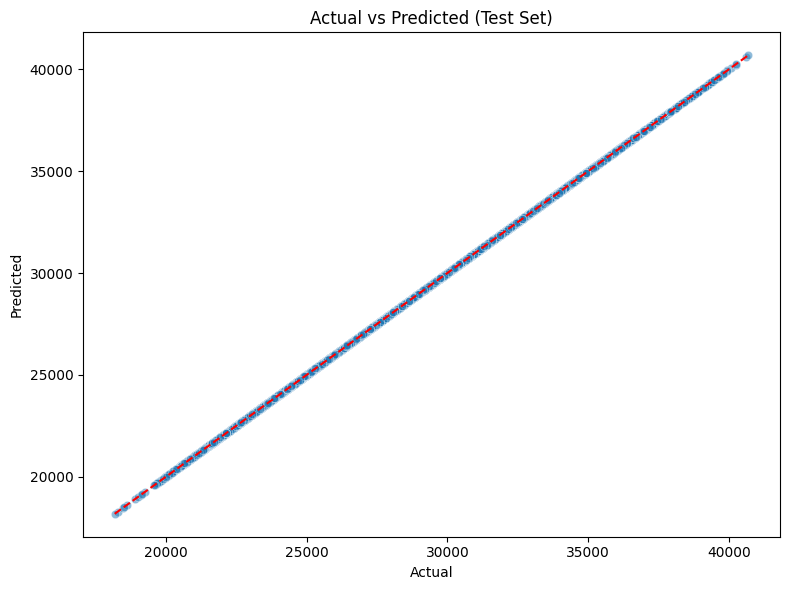

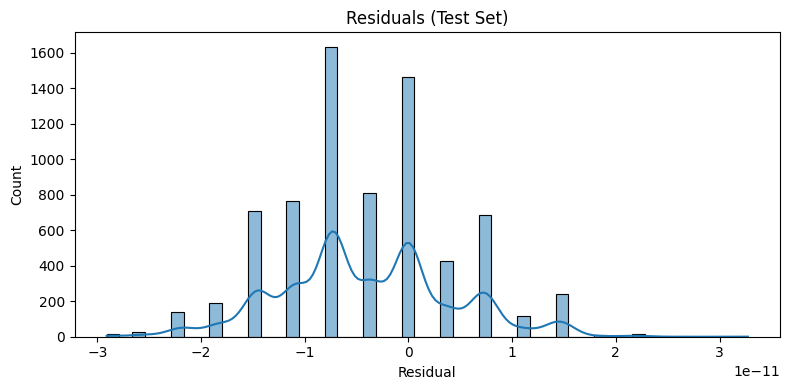

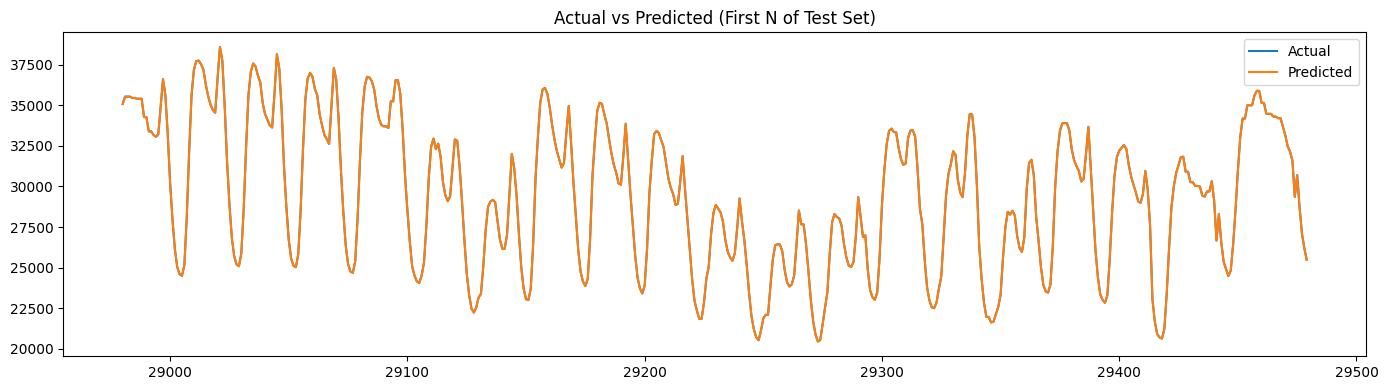

Saved diagnostic plots to models/


In [150]:
# --- Evaluation & diagnostic plots ---
import matplotlib.pyplot as plt
import seaborn as sns

# reload best saved model
import glob
model_files = glob.glob('models/best_model_*.pkl')
if not model_files:
    print('No saved models found in models/. Please run training cell first.')
else:
    latest = sorted(model_files)[-1]
    print('Loading', latest)
    obj = joblib.load(latest)
    best = obj['model']
    feats = obj.get('features', features)
    # Predictions on test set
    y_test_pred = best.predict(X_test[feats])
    # Scatter: actual vs pred
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted (Test Set)')
    plt.tight_layout()
    plt.savefig('models/actual_vs_pred.png')
    plt.show()
    # Residuals
    resid = y_test - y_test_pred
    plt.figure(figsize=(8,4))
    sns.histplot(resid, kde=True, bins=50)
    plt.title('Residuals (Test Set)')
    plt.xlabel('Residual')
    plt.tight_layout()
    plt.savefig('models/residuals.png')
    plt.show()
    # Time-series plot for a sample window
    n = min(500, len(y_test))
    plt.figure(figsize=(14,4))
    plt.plot(y_test.index[:n], y_test.values[:n], label='Actual')
    plt.plot(y_test.index[:n], y_test_pred[:n], label='Predicted')
    plt.legend()
    plt.title('Actual vs Predicted (First N of Test Set)')
    plt.tight_layout()
    plt.savefig('models/ts_pred_sample.png')
    plt.show()
    print('Saved diagnostic plots to models/')

In [151]:
# --- Save metrics and summary to CSV ---
metrics_df = summary.copy() if 'summary' in globals() else pd.DataFrame()
# add tuned results if present
try:
    tuned = pd.DataFrame([ { 'model': k, 'val_rmse': v.get('val_rmse'), 'test_rmse': v.get('test_rmse') } for k,v in results.items() ]).set_index('model')
    metrics_df = pd.concat([metrics_df, tuned[~tuned.index.isin(metrics_df.index)]]) if not metrics_df.empty else tuned
except Exception:
    pass

os.makedirs('models', exist_ok=True)
metrics_path = os.path.join('models', 'metrics_summary.csv')
metrics_df.to_csv(metrics_path)
print('Saved metrics to', metrics_path)

# Show contents
display(metrics_df)


Saved metrics to models\metrics_summary.csv


val_rmse       val_mae    val_r2     test_rmse      test_mae  \
model                                                                        
lr        8.581015e-12  6.683448e-12  1.000000  9.214556e-12  7.305102e-12   
rf        6.755905e+01  2.857840e+01  0.999787  1.227722e+02  2.222531e+01   
gb        7.286516e+01  5.232180e+01  0.999752  6.428484e+01  4.646768e+01   
rf_tuned  6.806918e+01           NaN       NaN  1.223541e+02           NaN   
gb_tuned  5.463565e+01           NaN       NaN  5.166696e+01           NaN   

           test_r2  
model               
lr        1.000000  
rf        0.999264  
gb        0.999798  
rf_tuned       NaN  
gb_tuned       NaN